# 

In [1]:
import numpy as np
import re
from collections import namedtuple

def loadLevels(file: str) -> list:
    """ load energy levels from a file """
    ptn = r'(\d+)\s*\"\s*[\[\(]*(\s*\d*\.\d*)[\?\]\)]?\"'

    levels = []
    with open(file, 'r') as f:
        for __line in f.read().splitlines():
            m = re.search(ptn, __line)
            if not m:
                continue
            levels.append(m.groups())
    return np.array(levels, 'float')

def loadLines(file: str) -> list:
    """ load spectral lines from a file.  """
    line = namedtuple('line', ['elem', 'sp', 'x', 'aki', 'acc', 'ei', 'ek', 'gi', 'gk'])
    ptn  = r'\s*'.join([
                            r'(?P<elem>[A-Za-z]{2})', 
                            r'(?P<sp>\d+)', 
                            r'\"(?P<x>\d*\.\d*)\"',
                            r'\"(?P<aki>\d*\.\d*[eE]?[+-]?\d*)\"',
                            r'(?P<acc>[A-E]{1,3}[+]?)',
                            r'\"(?P<ei>\d*\.\d*)\"',
                            r'\"(?P<ek>\d*\.\d*)\"',
                            r'(?P<gi>\d*)',
                            r'(?P<gk>\d*)',         
                        ])
    lines = []
    with open(file, 'r') as f:
        for __line in f.read().splitlines():
            m = re.search(ptn, __line)
            if m:
                lines.append( line( *m.groups() ) )
    return lines

def partition(T: float, sp: str) -> float:
    """ partition function """
    elem, sp = re.search(r'([a-z]{2})-(\d+)', sp.lower()).groups()
    
    g, E = loadLevels(f'../data/levels/{elem}-levels-{sp}.txt').T
    if not np.ndim(T):
        return np.sum(g * np.exp(-E/T))
    T = np.array(T)
    z = np.exp(-E / T[:, None]) @ g
    return z
    
class line:
    """ store a specral line data """
    __slots__ = 'elem', 'x', 'aki', 'ek', 'gk', 'acc', 'y', 
    _acc_dict = {
                    'AAA': 0.3 , 'AA': 1.0 , 'A+': 2.0 , 'A': 3.0,
                    'B+' : 7.0 , 'B' : 10.0, 'C+': 18.0, 'C': 25.0,
                    'D+' : 40.0, 'D' : 50.0, #'E' : 100.0,
                }

    def __init__(self, elem: str, x: float, aki: float, ek: float, gk: float, acc: float = 0.0) -> None:
        self.elem        = elem
        self.x, self.aki = x, aki
        self.ek, self.gk = ek, gk
        self.acc         = acc
        if isinstance(self.acc, str):
            if not self.acc.upper() in self._acc_dict.keys():
                raise ValueError('invalid value for acc')
        elif not isinstance(self.acc, (int, float)):
            raise TypeError("acc must be 'str' or a number")
    
    @property
    def akiAccuracy(self) -> float:
        """ accuracy in aki """
        if isinstance(self.acc, str):
            return self._acc_dict[self.acc] / 100.0
        return self.acc

    def __repr__(self) -> str:
        return f"line(elem='{self.elem}', x={self.x}, aki={self.aki}, acc={self.acc}, ek={self.ek}, gk={self.gk})"


def createLinesList(file: str, select: list = []):
    """ create a list of lines from file """
    lines = []
    for __line in loadLines(file):
        elem = '-'.join([ __line.elem.lower(), __line.sp ])
        if select and elem not in select:
            continue
        lines.append(
                        line(
                                elem, float(__line.x), float(__line.aki), float(__line.ek), float(__line.gk), __line.acc,
                            )
                    )
    return lines

In [2]:
# for display things
from IPython.display import HTML, display

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def LinesList2Table(lines: list):
    """ display the lines list as a table """
    def _line2row(o: line) -> str:
        return r"<td>" + r"</td><td>".join(map(str, [o.elem, o.x, o.aki, o.acc, o.ek, o.gk])) + r"</td>"

    tab  = r"<table>"
    tab += (r"<tr><th>" + r"</th><th>".join(['Element', 'Wavelength', 'Aki', 'Accuracy', 'Ek', 'gk']) + r"</th></tr>")
    for __line in lines:
        tab += r"<tr>" + _line2row( __line ) + r"</tr>"
    tab += r"</table>"
    return HTML(tab)

<!-- cu: 63.546, sn: 118.71, zn: 65.38, fe: 55.845, al: 26.981  -->
<!-- hc = 1239.84198 eV.nm -->

## Computation of Line Intensities

### Plasma Composition

Let's consider a multi-element plasma. Each element $X$ will have contribution from its neutral state and singly ionized state. 
In local thermal equilibrium (LTE), their ratio will be given by the *Saha ionization equation*

$$ 
    \frac{n_{X,1}}{n_{X,0}} 
        = 6.009 \times 10^{21} \frac{T_e^{3/2}}{n_e} 
            \cdot \frac{U_{X,1}(T_e)}{U_{X,0}(T_e)} 
                  \exp \left( - \frac{V_{X,0}}{T_e} \right) 
$$

where $n_{X,i}$ is the number density of the i-th species and $U_{X,i}(T_e)$ is its partition function at temperature $T_e$. $n_e$ 
is the electron density (equal to $\sum_X n_{X,1}$). $V_{X,0}$ is the ionization energy.

Denoting this ratio as $y$, contribution from each of the two species are 

$$ n_{X,1} = y n_{X,0} ~~ \text{and} ~~ n_{X,0} = \frac{1}{1 + y}n_{X} $$

### Lines Intensities at LTE

Intensity of a line at $\lambda_{ki}$, due to the transition $k \rightarrow i$ is given by 

$$ I_{ki} \propto \frac{n_{X,s} g_k e^{-E_k / T_e}}{U_{X,s}(T_e)} \cdot \frac{A_{ki}}{\lambda_{ki}} $$


In [3]:
def getIntensity(comp: dict, ne: float, Te: float, lines: list):
    """ get intensity of the lines in a LTE plasma """
    const = 6.009e+21 * Te**1.5 / ne
    MASS  = {'cu': 63.546,   'sn': 118.71,   'zn': 65.38,    'fe': 55.845,    'al': 26.981  } # atomic mass
    V     = {'cu': 7.726380, 'sn': 7.343918, 'zn': 9.394197, 'fe': 7.9024681, 'al': 5.985769} # ionization energy

    # check composition vector:
    if sum(comp.values()) != 1.0:
        raise ValueError("total composition must be 1")
    
    # change composition to numbers:
    num = np.array([ nx / MASS[x] for x, nx in comp.items() ])
    num = dict( zip( comp.keys(), num / sum(num) ) )

    # get the species contributions, weighted by partition function:
    nz = {}
    for x, nx in num.items():
        x1, x2 = '{}-1'.format(x), '{}-2'.format(x)
        z1, z2 = partition(Te, x1), partition(Te, x2)
        
        y  = const * (z2 / z1) * np.exp(-V[x] / Te)
        n1 = nx / (1.0 + y)
        n2 = n1 * y
        nz[x1] = n1 / z1; nz[x2] = n2 / z2

    # get the the line intensities
    return np.array([ nz[o.elem] * o.gk * np.exp(-o.ek / Te) * o.aki * (1.24e+03 / o.x) for o in lines ])


## Getting Concentration From Intensities

*Boltzmann Plots* are used to get element concentrations from line intensities. For this, use the  equation for intensity,

$$
    \frac{I_{ki} \lambda_{ki}}{g_k A_{ki}} = f\frac{n_{X,s}}{U_{X,s}(T_e)} e^{-E_k / T_e}
$$

Taking logarithm,

$$
    \log \left( \frac{I_{ki} \lambda_{ki}}{g_k A_{ki}} \right) 
        = \log \left( f\frac{n_{X,s}}{U_{X,s}(T_e)} \right) - \frac{1}{T_e} E_k
$$

This gives lines of the form $y_k = c + mx_k$ for each species.

To combine lines of neutral and ionised spacies of a same element, $X$, use Saha equation to get $n_{X,1}$ in terms of $n_{X,0}$.

$$
    \frac{n_{X,1}}{U_{X,1}(T_e)}
        = 6.009 \times 10^{21} \frac{T_e^{3/2}}{n_e} e^{-V_{X,0}/T_e} 
            \cdot \frac{n_{X,0}}{U_{X,0}(T_e)}
$$

i.e.,

$$
    \log \left( \frac{I_{ki} \lambda_{ki}}{g_k A_{ki}} \right) 
        = \log \left( f\frac{n_{X,0}}{U_{X,0}(T_e)} \right) 
            + s \log \left( 6.009 \times 10^{21} \frac{T_e^{3/2}}{n_e} \right)
            - \frac{1}{T_e} ( E_k + s V_{X,0} ) 
$$

To combine lines of different element, use $n_{X,0} = n_{X} / (1 + y_{X,10})$, where $\sum_{X}n_X = 1$. i.e.,

$$
    \log \left( \frac{I_{ki} \lambda_{ki}}{g_k A_{ki}} \right) 
        = \log \left( f\frac{n_{X}}{(1 + y_{X,10}) U_{X,0}(T_e)} \right) 
            + s \log \left( 6.009 \times 10^{21} \frac{T_e^{3/2}}{n_e} \right)
            - \frac{1}{T_e} ( E_k + s V_{X,0} ) 
$$

i.e., 

$$
    \log \left( \frac{I_{ki} \lambda_{ki}}{g_k A_{ki}} \right) 
        - s \log \left( 6.009 \times 10^{21} \frac{T_e^{3/2}}{n_e} \right)
        - \log \left( \frac{n_{X}}{(1 + y_{X,10}) U_{X,0}(T_e)} \right) 
        = \log f - \frac{1}{T_e} ( E_k + s V_{X,0} ) 
$$

i.e., a line of the form $y_k = c + mx_k$, where, $c = \log f$, $m = -1/T_e$ and $x_k = E_k + sV_{X,0}$ and

$$
    y_k = \log \left( \frac{I_{ki} \lambda_{ki}}{g_k A_{ki}} \right) 
            - s \log \left( 6.009 \times 10^{21} \frac{T_e^{3/2}}{n_e} \right)
            - \log \left( \frac{n_{X}}{(1 + y_{X,10}) U_{X,0}(T_e)} \right) \\
        =  \log \left( \frac{I_{ki} \lambda_{ki}}{g_k A_{ki}} \right)  + B_{X,s}(T_e, n_e) + D_X(T_e, n_e)
$$


In [4]:
def boltzCoords(lines: list, intens: list, type_: int = 0, ne: float = ..., Te: float = ..., comp: dict = ...):
    """ Boltzmann plot coordinates. """
    MASS  = {'cu': 63.546,   'sn': 118.71,   'zn': 65.38,    'fe': 55.845,    'al': 26.981  } # atomic mass
    V     = {'cu': 7.726380, 'sn': 7.343918, 'zn': 9.394197, 'fe': 7.9024681, 'al': 5.985769} # ionization energy

    # check composition vector:
    if sum(comp.values()) != 1.0:
        raise ValueError("total composition must be 1")
    
    # change composition to numbers:
    num = np.array([ nx / MASS[x] for x, nx in comp.items() ])
    num = dict( zip( comp.keys(), num / sum(num) ) )

    if type_:
        const = 6.009e+21 * Te**1.5 / ne

    # species correction B:
    B = np.log(const) if type_ else 0.0

    if type_ == 2:
        # element corrections D:
        D     = {}
        for x, nx in num.items():
            x1, x2 = '{}-1'.format(x), '{}-2'.format(x)
            z1, z2 = partition(Te, x1), partition(Te, x2)
            y      = const * (z2 / z1) * np.exp(-V[x] / Te)
            Dx     = np.log( nx / (1.0 + y) / z1 )
            D[x]   = Dx

    # get coordinates:
    x, y = [], []
    for line_, int_ in zip(lines, intens):
        line_:line
        X, s   = line_.elem.split('-')

        xk, yk = line_.ek, np.log(int_ * line_.x / line_.aki / line_.gk)
        
        if int(s) == 2 and type_:
            xk += V[X]
            yk -= B

        if type_ == 2:
            yk -= D[X] # apply element corrections
        
        x.append(xk)
        y.append(yk)
    return x, y# apply element corrections:

In [5]:
def plotLines(lines: list, intens: list, type_: int = 0, ne: float = ..., Te: float = ..., comp: dict = ...):
    """ Plot spectral lines and Boltzmann plane. """
    COLOURS = {'cu': 'red', 'sn': 'purple', 'zn': 'orange', 'fe': 'green', 'al': 'black'}

    fig, (ax, ax2) = plt.subplots(1, 2, figsize = [18,6])

    _elems = []
    for int_, line_ in zip(intens, lines):
        X = line_.elem.split('-')[0]
        if X not in _elems:
            _elems.append(X)

        ax.plot(line_.x, int_, 'o', ms = 5, color = COLOURS[X])
        ax.vlines(line_.x, 0.0, int_, colors = COLOURS[X])
        ax.text(
                    line_.x, int_, line_.elem, 
                    # rotation = 90, 
                    horizontalalignment = 'center',
               )

    # make legends
    for X in _elems:
        ax.plot([], [], '-o', ms = 5, color = COLOURS[X], label = X)
    ax.legend(
                bbox_to_anchor = (0.0, 1.02, 1.0, 0.102),
                loc = 'lower left', ncol = len(X),
                mode = 'expand', borderaxespad = 0,
            )
    ax.set(xlabel = '$\\lambda$', ylabel = 'I')

    x, y = boltzCoords(lines, intens, type_, ne, Te, comp, )

    for xk, yk, line_ in zip(x, y, lines):
        X = line_.elem.split('-')[0]
        ax2.plot(xk, yk, 'o', ms = 5, color = COLOURS[X])
        # ax.text(
        #             xk, yk, line_.elem, 
        #             # rotation = 90, 
        #             horizontalalignment = 'center',
        #        )

    # make legends
    for X in _elems:
        ax2.plot([], [], 'o', ms = 5, color = COLOURS[X], label = X)
    ax2.legend(
                bbox_to_anchor = (0.0, 1.02, 1.0, 0.102),
                loc = 'lower left', ncol = len(X),
                mode = 'expand', borderaxespad = 0,
            )
    ax2.set(xlabel = 'X', ylabel = 'Y')

    plt.show()
    return

## Expt. 1: Copper-Tin plasma

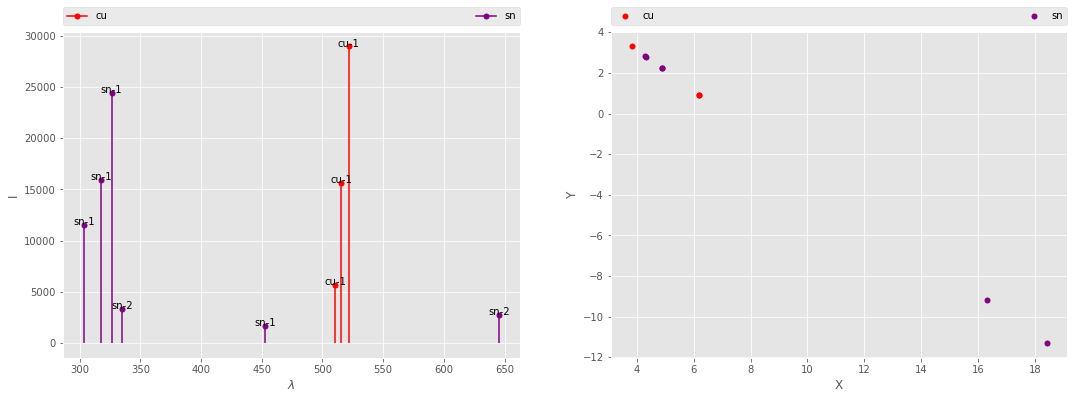

In [6]:
# load some lines:
LINES   = createLinesList('percistent_lines.txt', ['cu-1', 'cu-2', 'sn-1', 'sn-2'], )
# display(LinesList2Table(LINES))

I = getIntensity({'cu': 0.7, 'sn': 0.3}, 1.0e+17, 1.0, LINES)


plotLines(LINES, I, 2, 1.0e+17, 1.0, {'cu': 0.7, 'sn': 0.3})

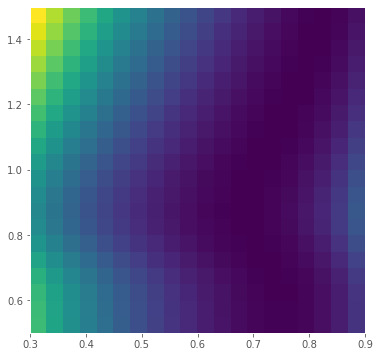

(0.9999755225331746, {'cu': 0.699993011399786, 'sn': 0.300006988600214})

In [14]:
def SSR(lines: list, intens: list, ne: float, Te: float, comp: dict):
    """ Sum of squared residuals to boltzmann plot fit. """
    x, y = boltzCoords(lines, intens, 2, ne, Te, comp)
    x, y = np.array(x), np.array(y)
    m, c = np.polyfit(x, y, deg = 1)
    return np.sum( (y - (m*x + c))**2 )

def SSRplane(lines: list, intens: list, ne: float, Ts: list, elem: list, C1: list):
    """ Variation of SSR with Te and C1 for binary alloys. """
    if min(C1) < 0 or max(C1) > 1:
        raise ValueError("C1 must be in [0, 1]")
    if len(elem) != 2:
        raise ValueError("must be a binary alloy")

    ssr = []
    for Te in Ts:
        ssr_i = []
        for c1 in C1:
            comp = dict( zip( elem, [c1, 1.0 - c1] ) )

            ssr_i.append( SSR(lines, intens, ne, Te, comp) )
        ssr.append( ssr_i )

    return np.array(ssr)

import scipy.optimize as opt  

def optimiseTC(lines: list, intens: list, ne: float, Te0: float, comp0: dict):
    """ Optimize the Te and concentration. """
    def f(__x, __lines, __int, __ne, __elem):
        Te = __x[0]
        cs = __x[1:]
        cn = 100.0 - sum(cs)
        cs = np.array([*cs, cn]) / 100.0

        comp = dict( zip( __elem,  cs) )

        return SSR(__lines, __int, __ne, Te, comp)

    __c = list(comp0.values())
    if sum(__c) != 100.0:
        raise ValueError("total concentration should be 1")
    
    elem = list(comp0.keys())
    x0   = [Te0, *__c[:-1] ]

    res = opt.minimize(f, x0, args = (lines, intens, ne, elem))

    Te = res.x[0]
    cs = res.x[1:] / 100.0
    cs = np.append(cs, 1 - sum(cs))
    return Te, dict(zip(elem, cs))



def test1(lines: list, intens: list, ne: float, x0: list):
    COLOURS = {'cu': 'red', 'sn': 'purple', 'zn': 'orange', 'fe': 'green', 'al': 'black'}
    popt = optimiseTC(lines, intens, ne, x0[0], x0[1])

    T,C = np.mgrid[0.5:1.5:21j], np.mgrid[0.3:0.9:21j]
    ssr = SSRplane(lines, intens, 1.0e+17, T, ['cu', 'sn'], C)

    fig, ax = plt.subplots(figsize = [6, 6])
    ax.pcolor(C, T, ssr)
    plt.show()

    Te, comp = popt

    x, y = boltzCoords(lines, intens, 2, ne, Te, comp)

    _elems = []
    for int_, line_ in zip(intens, lines):
        X = line_.elem.split('-')[0]
        if X not in _elems:
            _elems.append(X)

        ax.plot(line_.x, int_, 'o', ms = 5, color = COLOURS[X])
        ax.vlines(line_.x, 0.0, int_, colors = COLOURS[X])
        ax.text(
                    line_.x, int_, line_.elem, 
                    # rotation = 90, 
                    horizontalalignment = 'center',
               )

    # make legends
    for X in _elems:
        ax.plot([], [], '-o', ms = 5, color = COLOURS[X], label = X)
    ax.legend(
                bbox_to_anchor = (0.0, 1.02, 1.0, 0.102),
                loc = 'lower left', ncol = len(X),
                mode = 'expand', borderaxespad = 0,
            )
    ax.set(xlabel = '$\\lambda$', ylabel = 'I')

    x, y = boltzCoords(lines, intens, type_, ne, Te, comp, )

    for xk, yk, line_ in zip(x, y, lines):
        X = line_.elem.split('-')[0]
        ax2.plot(xk, yk, 'o', ms = 5, color = COLOURS[X])
        # ax.text(
        #             xk, yk, line_.elem, 
        #             # rotation = 90, 
        #             horizontalalignment = 'center',
        #        )

    # make legends
    for X in _elems:
        ax2.plot([], [], 'o', ms = 5, color = COLOURS[X], label = X)
    ax2.legend(
                bbox_to_anchor = (0.0, 1.02, 1.0, 0.102),
                loc = 'lower left', ncol = len(X),
                mode = 'expand', borderaxespad = 0,
            )
    ax2.set(xlabel = 'X', ylabel = 'Y')